![tower_bridge](tower_bridge.jpeg)

As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `MLflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [67]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline


# Read in the data
weather = pd.read_csv("london_weather.csv")

# Start coding here
# Use as many cells as you like

In [68]:
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [69]:
weather.isna().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [70]:
weather.duplicated().sum()

0

In [71]:
# Convert 'date' column to datetime format
weather['date'] = pd.to_datetime(weather['date'], format='%Y%m%d')

# Sort the dataset by date
weather = weather.sort_values(by='date').reset_index(drop=True)

# Check for missing values and fill or remove them
weather = weather.dropna()  # Drop rows with missing values (or use df.fillna(value) for imputation)

# Convert numeric columns to appropriate data types
numeric_columns = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
weather[numeric_columns] = weather[numeric_columns].apply(pd.to_numeric)

# Remove duplicates
weather = weather.drop_duplicates()

In [72]:
# Handle outliers (example: clipping temperature values to a reasonable range)
weather['max_temp'] = weather['max_temp'].clip(lower=-50, upper=50)
weather['mean_temp'] = weather['mean_temp'].clip(lower=-50, upper=50)
weather['min_temp'] = weather['min_temp'].clip(lower=-50, upper=50)

weather['precipitation'] = weather['precipitation'].clip(lower=0, upper=500)  # Assuming max 500mm as reasonable

weather['snow_depth'] = weather['snow_depth'].clip(lower=0)  # Snow depth should not be negative

In [73]:
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


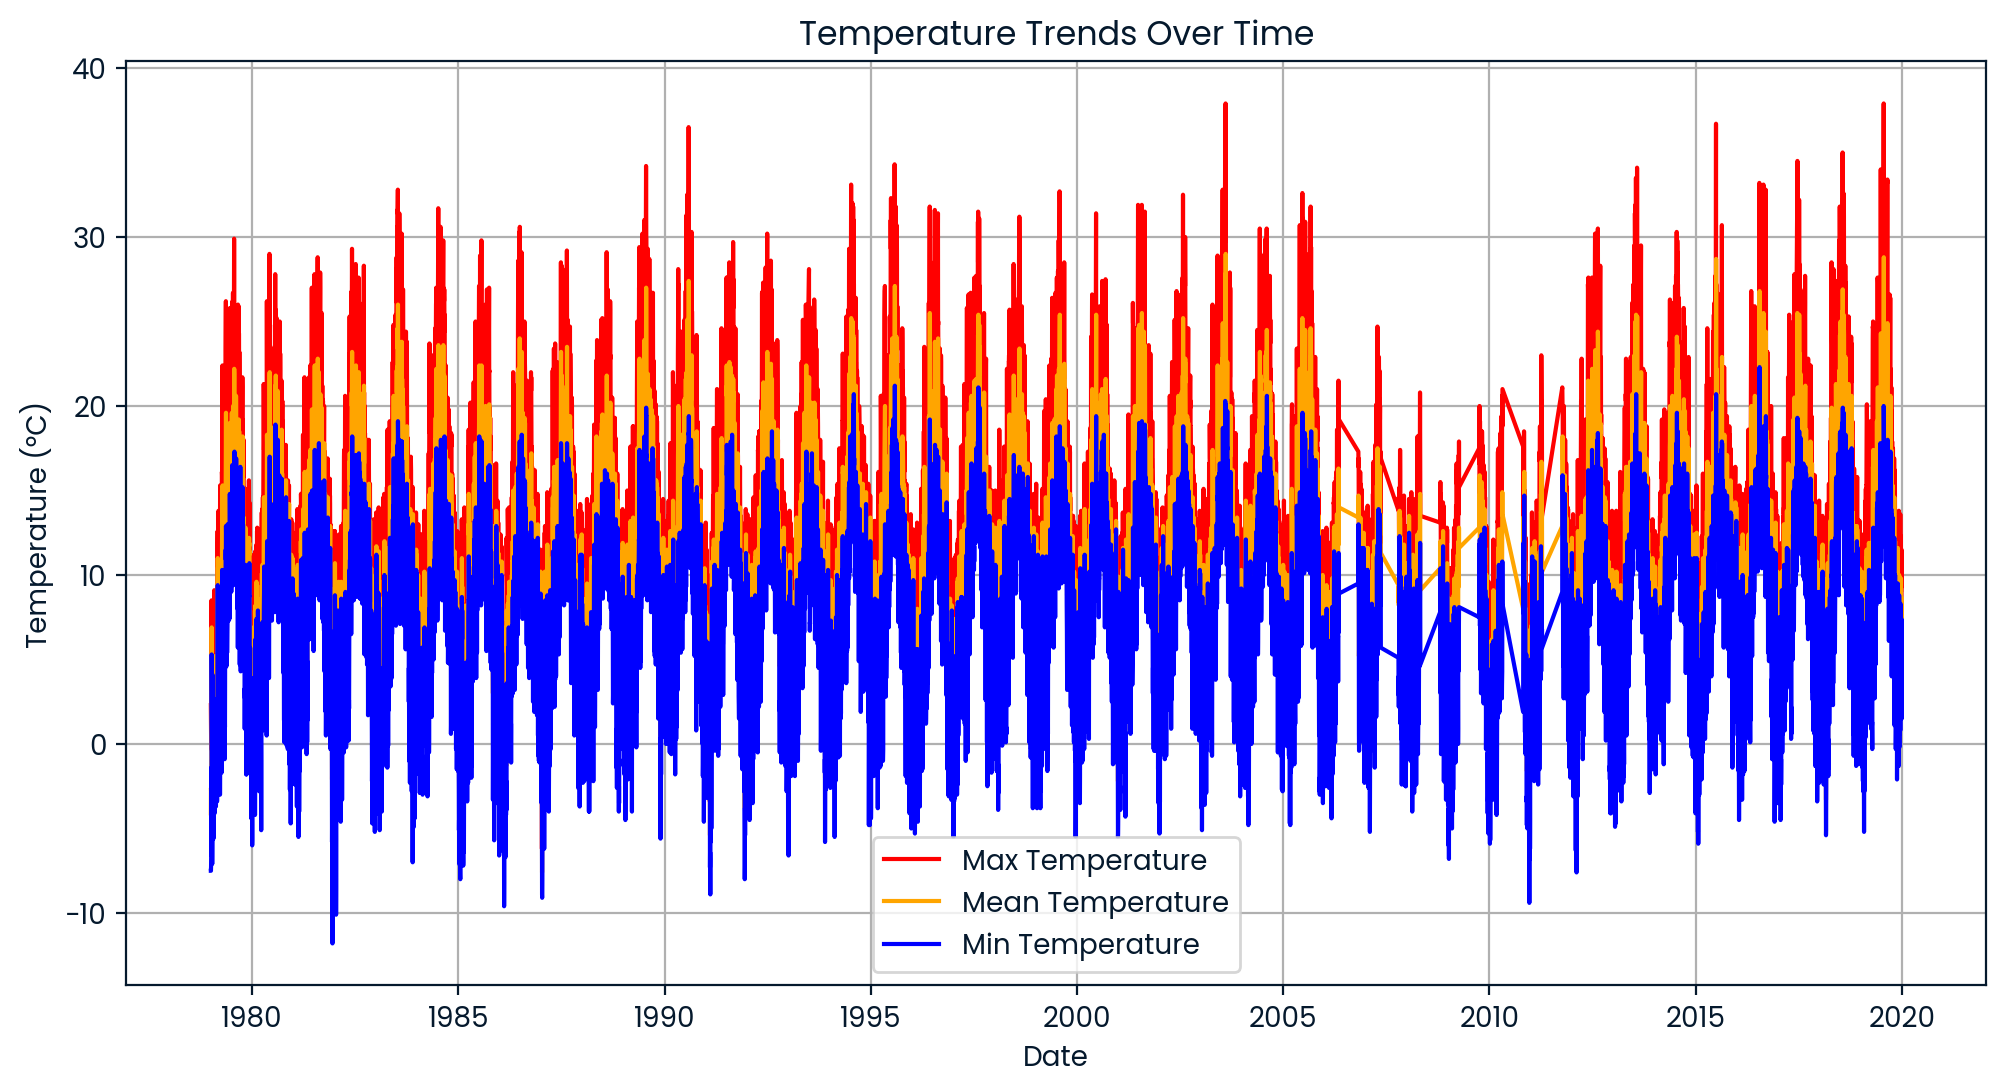

In [74]:
# Visualizing temperature trends
plt.figure(figsize=(12, 6))
plt.plot(weather['date'], weather['max_temp'], label='Max Temperature', color='red')
plt.plot(weather['date'], weather['mean_temp'], label='Mean Temperature', color='orange')
plt.plot(weather['date'], weather['min_temp'], label='Min Temperature', color='blue')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Trends Over Time')
plt.legend()
plt.grid()
plt.show()

In [75]:
# Feature selection
features = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
X = weather[features]
y = weather['mean_temp']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Preprocessing pipeline
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [78]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [79]:
# Initialize MLflow
mlflow.set_experiment("mean_temperature_prediction")
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
}

In [80]:
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"{name} RMSE: {rmse}")
        
        mlflow.log_param("model_type", name)
        mlflow.log_metric("rmse", rmse)
        mlflow.sklearn.log_model(model, name)

# Search MLflow runs
experiment_results = mlflow.search_runs()

LinearRegression RMSE: 0.9009868034247633
DecisionTree RMSE: 1.2773776858302843
RandomForest RMSE: 0.886558227931579


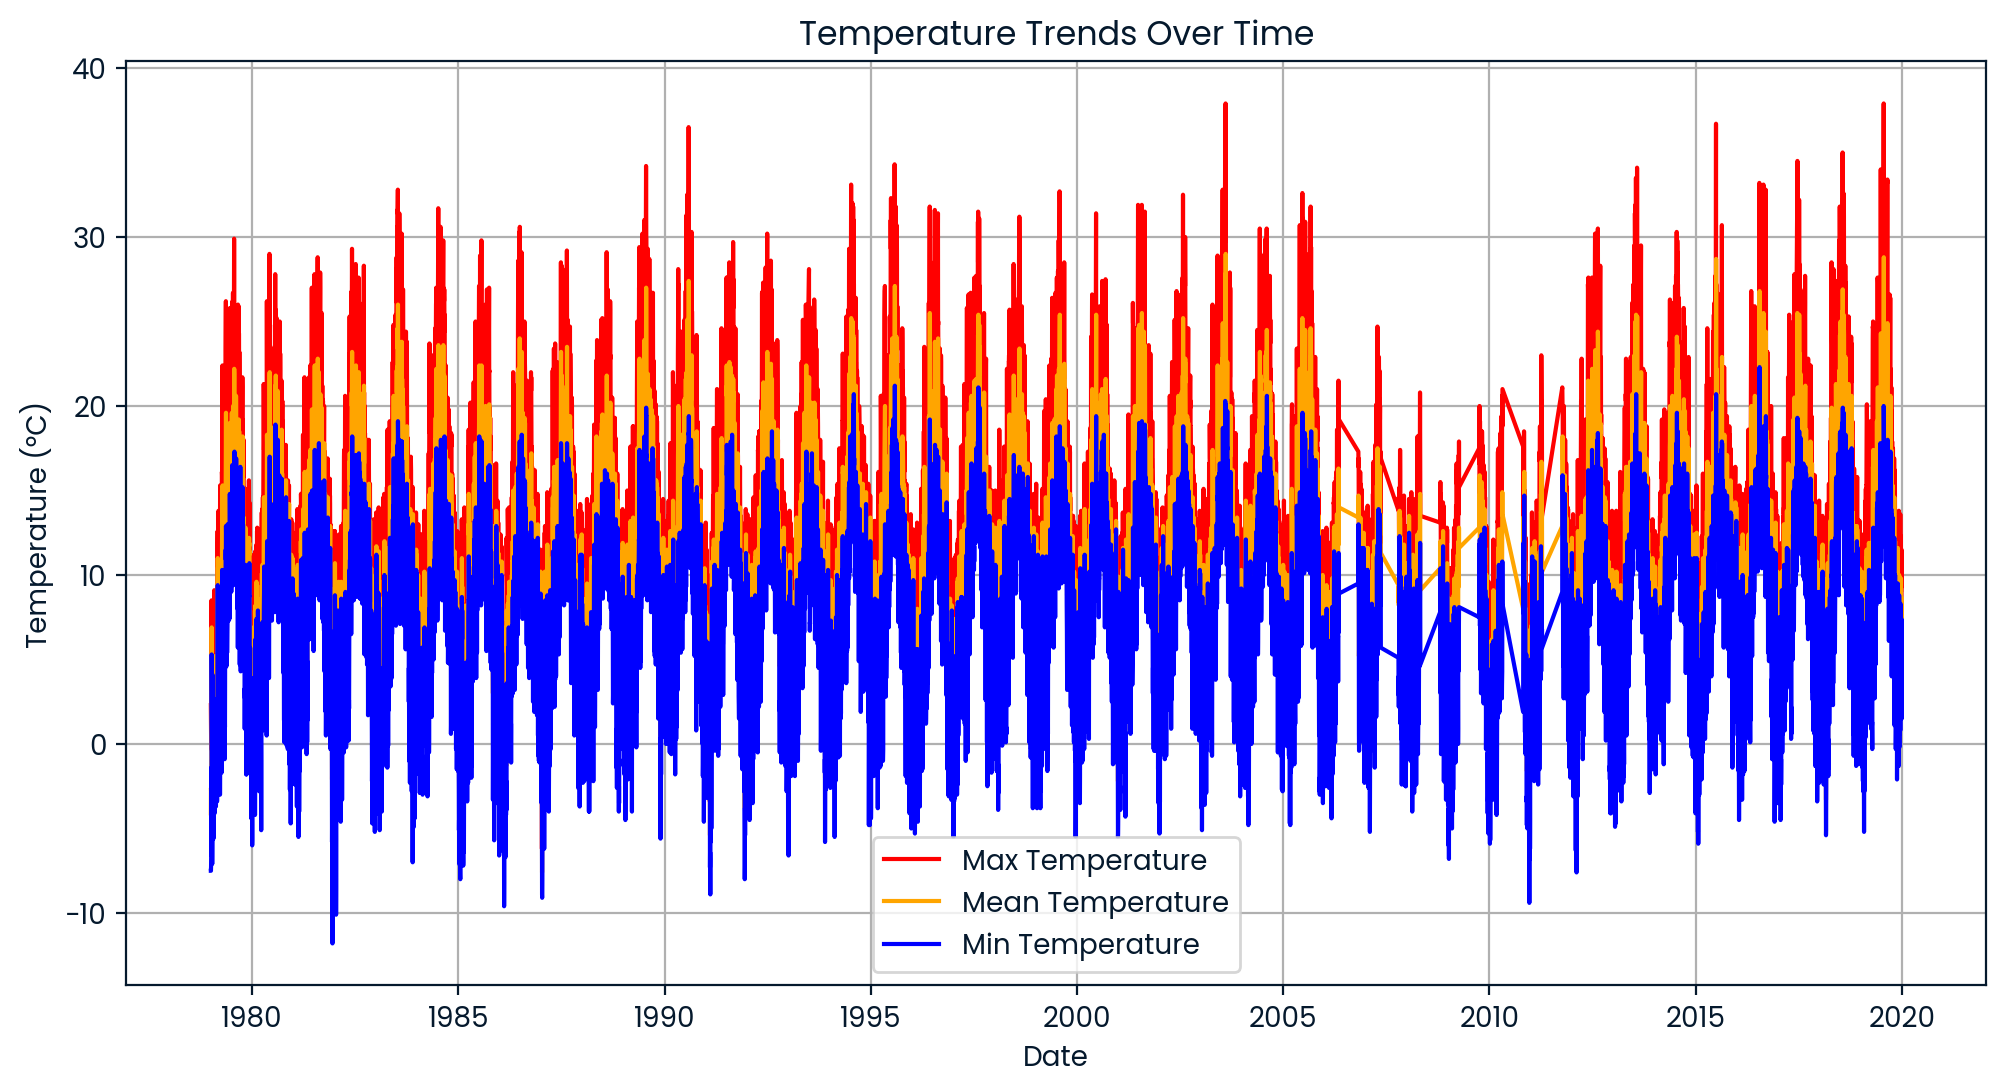

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(weather['date'], weather['max_temp'], label='Max Temperature', color='red')
plt.plot(weather['date'], weather['mean_temp'], label='Mean Temperature', color='orange')
plt.plot(weather['date'], weather['min_temp'], label='Min Temperature', color='blue')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Trends Over Time')
plt.legend()
plt.grid()
plt.show()